# SingleCell Data Analysis on the GPU with Pearson Residuals
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 200000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp
import sys

import rapids_singlecell as rsc
from rapids_singlecell.cunnData import cunnData


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

In [2]:
import rmm
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/200000.h5ad")
adata.var_names_make_unique()

CPU times: user 336 ms, sys: 1.67 s, total: 2.01 s
Wall time: 5.08 s


In [5]:
adata.shape

(200000, 27998)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [6]:
%%time
cudata = cunnData(adata=adata)

CPU times: user 1.72 s, sys: 1.86 s, total: 3.58 s
Wall time: 3.65 s


Verify the shape of the resulting sparse matrix:

In [7]:
cudata.shape

(200000, 27998)

And the number of non-zero values in the matrix:

In [8]:
cudata.nnz

399277814

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 8.828320741653442


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 8.28 ms, sys: 128 µs, total: 8.4 ms
Wall time: 8.25 ms


In [12]:
%%time
rsc.pp.caluclate_qc(cudata,qc_vars=["MT"])

CPU times: user 526 ms, sys: 107 ms, total: 633 ms
Wall time: 711 ms


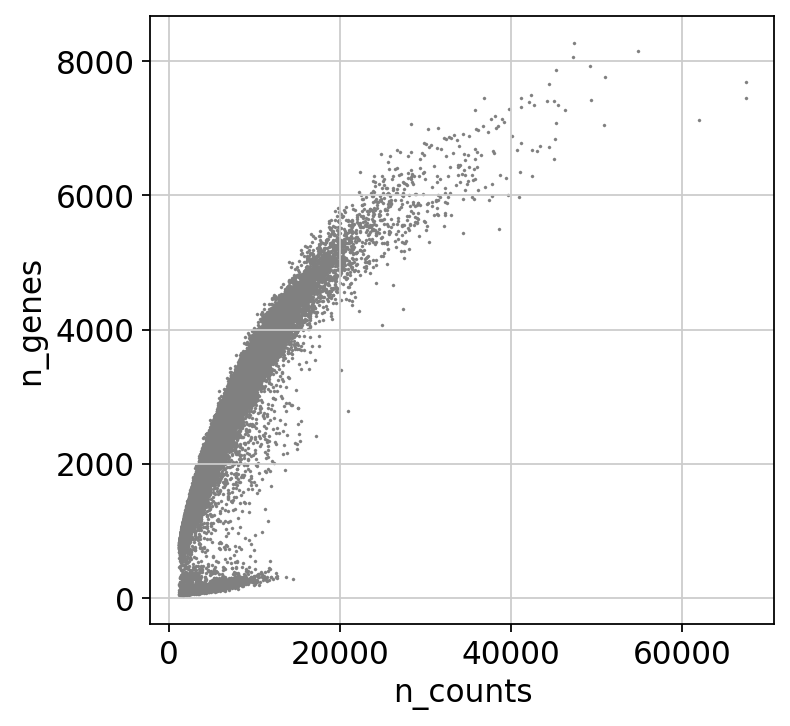

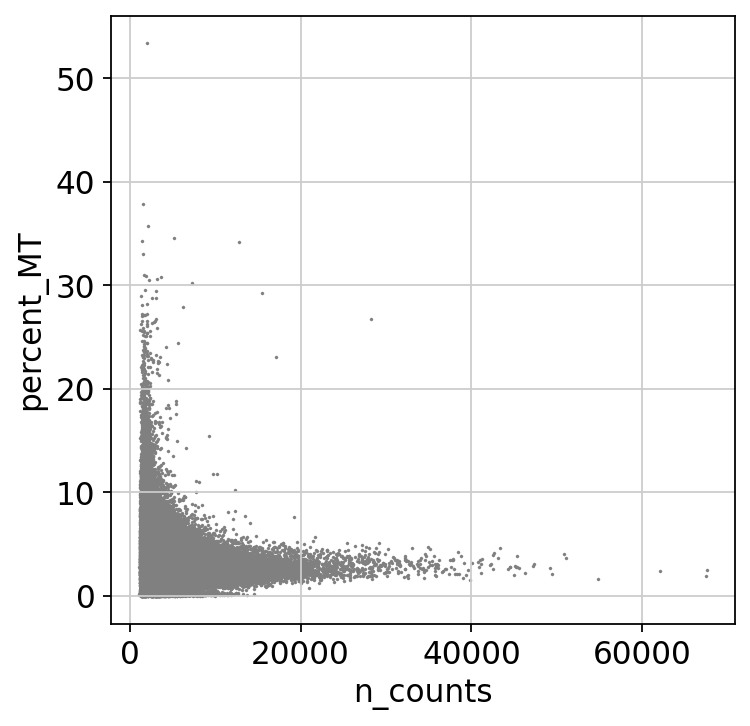

In [13]:
rsc.pp.plt_scatter(cudata,"n_counts","n_genes")
rsc.pp.plt_scatter(cudata,"n_counts","percent_MT")

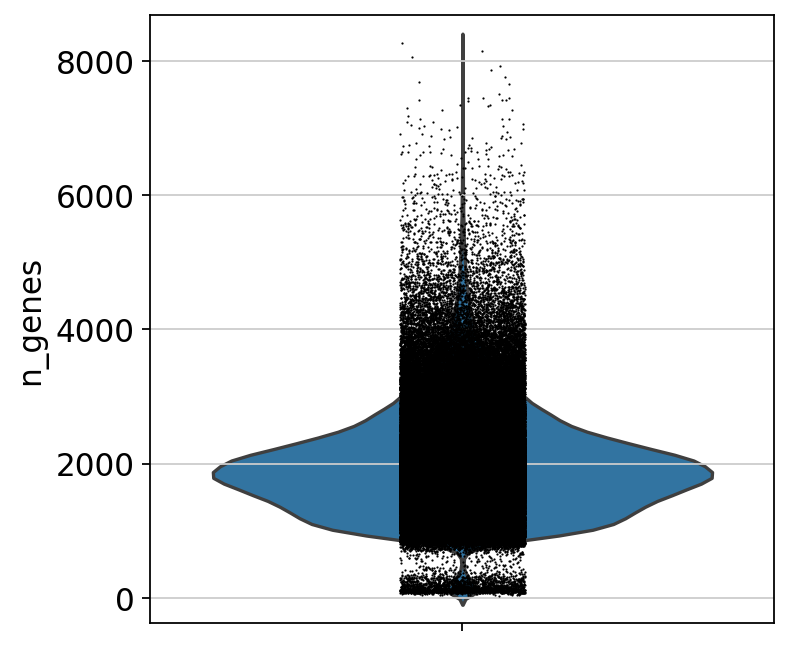

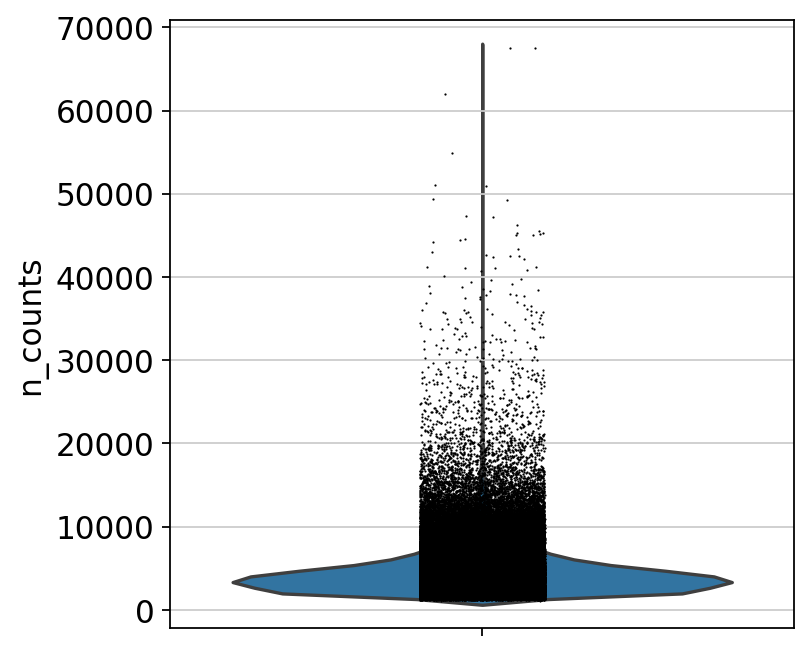

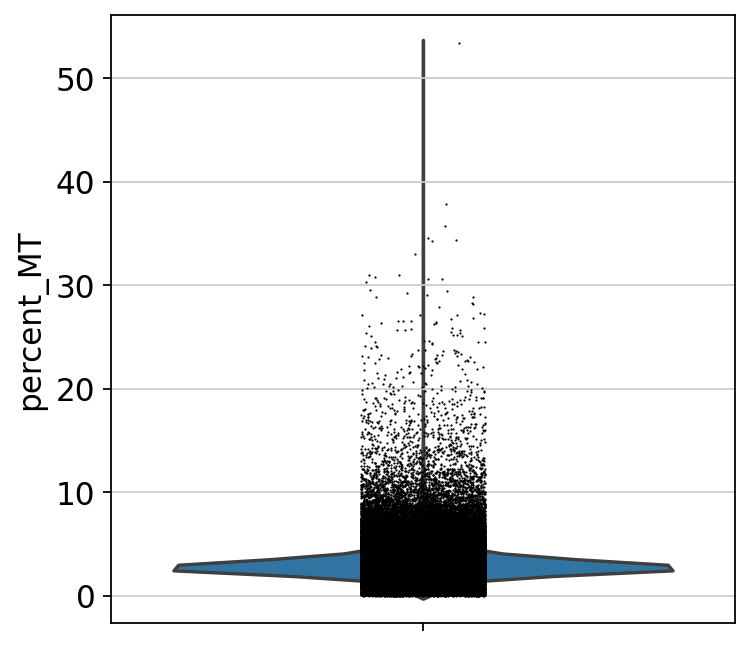

In [14]:
rsc.pp.plt_violin(cudata,key="n_genes")
rsc.pp.plt_violin(cudata,key="n_counts")
rsc.pp.plt_violin(cudata,key="percent_MT")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

The size of our count matrix is now reduced.

In [15]:
%%time
rsc.pp.filter_cells(cudata,qc_var="n_genes", min_count=500,max_count= 4000)
rsc.pp.filter_cells(cudata,qc_var="n_counts", max_count= 20000)
cudata = cudata[cudata.obs["percent_MT"] < 10]

filtered out 6066 cells
filtered out 2 cells
CPU times: user 77.3 ms, sys: 31.5 ms, total: 109 ms
Wall time: 111 ms


We copy the raw counts to the layer `counts`

In [16]:
cudata.layers["counts"] = cudata.X.copy()

### Log-Normalize counts

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [17]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 3.06 ms, sys: 127 µs, total: 3.19 ms
Wall time: 4.72 ms


Next, we log transform the count matrix.

In [18]:
rsc.pp.log1p(cudata)

Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [19]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 807 ms, sys: 439 ms, total: 1.25 s
Wall time: 1.25 s


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `pearson_residuals` for selecting highly variable genes with `.layers["counts"]`

In [20]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="pearson_residuals",layer = "counts")

CPU times: user 9.08 s, sys: 1.79 s, total: 10.9 s
Wall time: 11.3 s


Now we restrict our cunndata object to the highly variable genes.

In [21]:
%%time
rsc.pp.filter_highly_variable(cudata)

CPU times: user 216 ms, sys: 68.2 ms, total: 284 ms
Wall time: 569 ms


In [22]:
cudata.shape

(192398, 5000)

### Normalize

We normalize the raw counts matrix with pearson_residuals.

In [23]:
%%time
cudata.layers["pearson_residuals"] = rsc.pp.normalize_pearson_residuals(cudata,layer= "counts",inplace = False)

CPU times: user 3.14 s, sys: 237 ms, total: 3.38 s
Wall time: 4.16 s


Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [24]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 940 ms, sys: 663 ms, total: 1.6 s
Wall time: 1.61 s


In [25]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 23.962424993515015


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [26]:
%%time
rsc.tl.pca(adata, n_comps = 100, layer = "pearson_residuals")

CPU times: user 3.74 s, sys: 1.73 s, total: 5.47 s
Wall time: 5.52 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

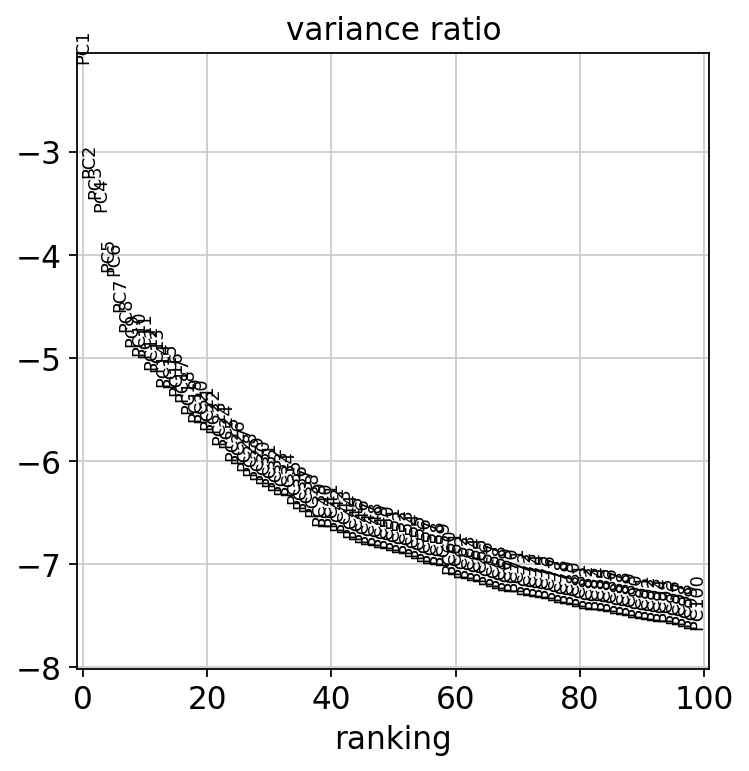

In [27]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [28]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, method='rapids')

CPU times: user 9.53 s, sys: 163 ms, total: 9.69 s
Wall time: 10.1 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [29]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 1.73 s, sys: 14.9 ms, total: 1.74 s
Wall time: 1.75 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [30]:
%%time
rsc.tl.louvain(adata, resolution=1)

CPU times: user 908 ms, sys: 166 ms, total: 1.07 s
Wall time: 1.1 s


In [31]:
%%time
rsc.tl.leiden(adata,resolution=1)

CPU times: user 421 ms, sys: 149 ms, total: 571 ms
Wall time: 578 ms


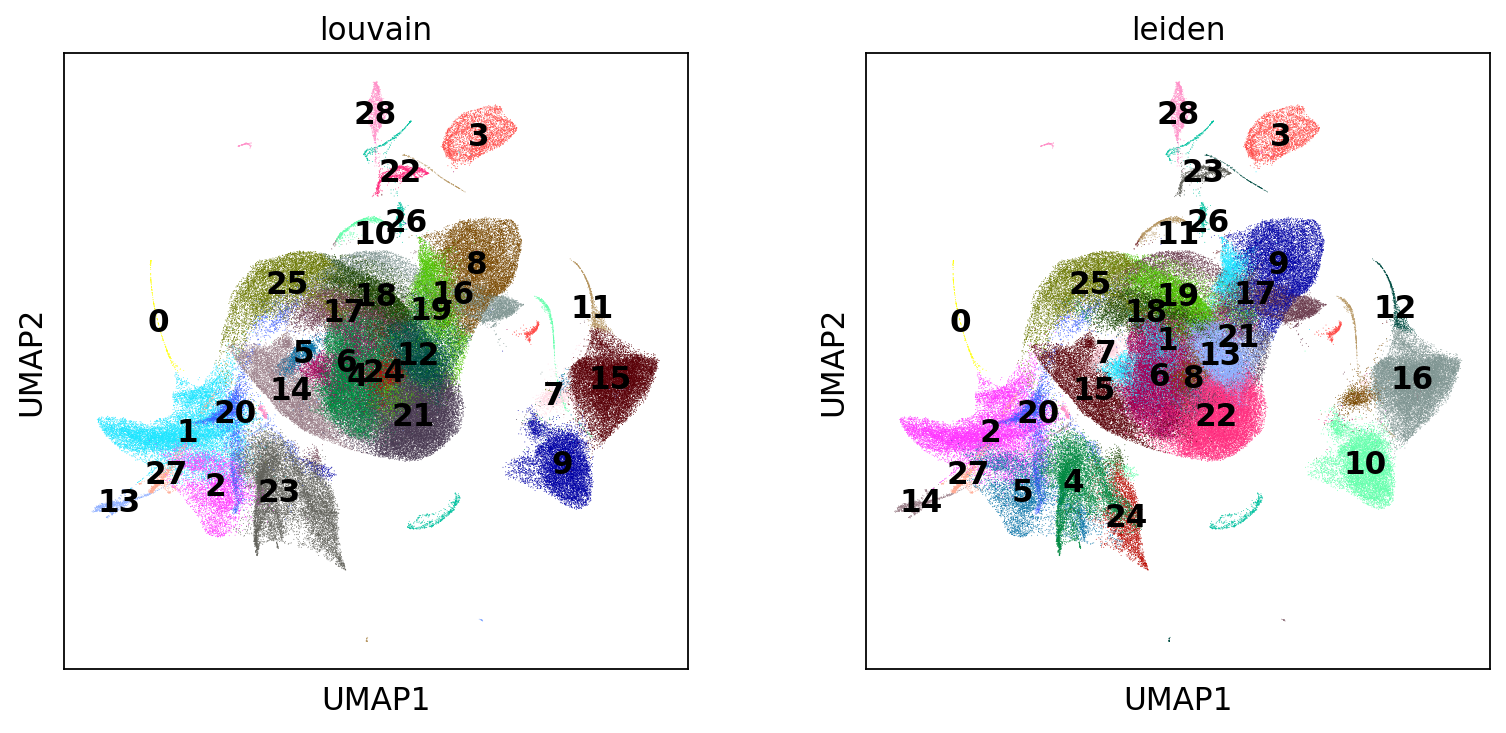

CPU times: user 1.86 s, sys: 179 ms, total: 2.04 s
Wall time: 1.83 s


In [32]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

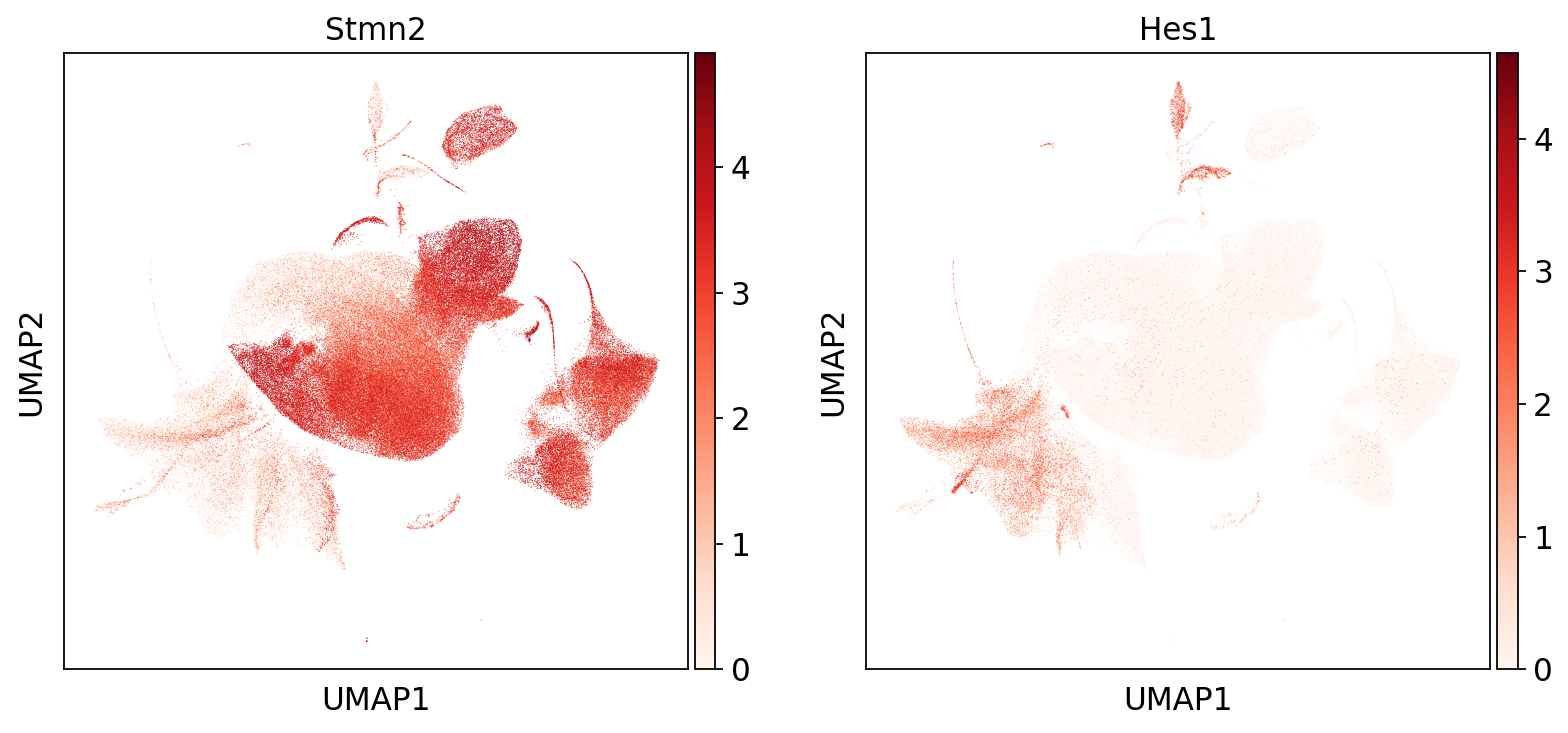

CPU times: user 2.12 s, sys: 185 ms, total: 2.3 s
Wall time: 2.09 s


In [33]:
%%time
sc.pl.umap(adata, color=["Stmn2","Hes1"],legend_loc = 'on data', cmap="Reds")

In [34]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 47.24793457984924
